In [65]:
import os
from pathlib import Path
import numpy as np
from scipy.sparse import coo_array
import skimage.exposure
from scipy.sparse import coo_matrix
import warnings
from io import StringIO
import random
import torch
import numpy as np
import rasterio


In [66]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)

In [67]:


def load_whu_longkou(data_path: Path, candidate_counts: dict, num_train_per_class=10, seed=42):
    """
    加载 WHU-Hi-LongKou 数据集：
    - 从每类中抽取固定数量作为候选样本
    - 从候选中抽取 num_train_per_class 个作为训练样本
    - 所有 ground truth 标签 > 0 的像素作为测试集
    """
    random.seed(seed)
    np.random.seed(seed)

    # 读取 hyperspectral 数据
    with rasterio.open(data_path / "WHU-Hi-LongKou.tif") as src:
        hyperspectral = src.read()  # shape: (bands, height, width)
    c, h, w = hyperspectral.shape

    # 读取 ground truth 标签
    with rasterio.open(data_path / "WHU-Hi-LongKou_gt.tif") as src:
        gt = src.read(1)  # shape: (height, width)

    label_dict = {
        1: '玉米', 2: '棉花', 3: '芝麻',
        4: '圆叶大豆', 5: '长叶大豆', 6: '水稻',
        7: '水体', 8: '房屋和道路', 9: '混合杂草',
    }

    train_rows, train_cols, train_data = [], [], []
    candidate_rows, candidate_cols, candidate_data = [], [], []

    for label, cand_count in candidate_counts.items():
        coords = np.argwhere(gt == label)
        if len(coords) < cand_count:
            raise ValueError(f"类 {label} 样本不足，只有 {len(coords)}，无法抽取 {cand_count} 个候选样本")
        np.random.shuffle(coords)

        candidate_coords = coords[:cand_count]
        train_coords = candidate_coords[:num_train_per_class]

        # 训练样本
        for r, c in train_coords:
            train_rows.append(r)
            train_cols.append(c)
            train_data.append(label)

        # 候选样本（包含训练）
        for r, c in candidate_coords:
            candidate_rows.append(r)
            candidate_cols.append(c)
            candidate_data.append(label)

    # 构建稀疏矩阵
    train_truth = coo_matrix((train_data, (train_rows, train_cols)), shape=(h, w), dtype=int)
    candidate_truth = coo_matrix((candidate_data, (candidate_rows, candidate_cols)), shape=(h, w), dtype=int)

    # 所有标签 > 0 的都作为测试样本
    test_rows, test_cols = np.where(gt > 0)
    test_data = gt[test_rows, test_cols]
    test_truth = coo_matrix((test_data, (test_rows, test_cols)), shape=(h, w), dtype=int)

    info = {
        'n_band': c,
        'width': w,
        'height': h,
        'label_dict': label_dict
    }

    return hyperspectral, train_truth, candidate_truth, test_truth, info
data_path = Path(r"E:\code\-\对比学习\fx\WHU\Tiff_format\WHU-Hi-LongKou")

candidate_counts = {
    1: 300, 2: 300, 3: 300,
    4: 300, 5: 300, 6: 300,
    7: 300, 8: 300, 9: 300
}

whu, train_truth, candidate_truth, test_truth, info = load_whu_longkou(
    data_path,
    candidate_counts=candidate_counts,
    num_train_per_class=10
)

print(f"WHU shape: {whu.shape}")  # 应该是 (270, 400, 550)
print(f"Train samples: {train_truth.count_nonzero()}")         # 90
print(f"Candidate samples: {candidate_truth.count_nonzero()}") # 2700
print(f"Test samples: {test_truth.count_nonzero()}")           # 应该接近你截图里的 201842

print(f"Test samples: {test_truth.count_nonzero()}")           # 应该接近你截图里的 201842



d:\Anaconda\envs\pytorch\lib\site-packages\rasterio\__init__.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


WHU shape: (270, 550, 400)
Train samples: 90
Candidate samples: 2700
Test samples: 204542
Test samples: 204542


In [68]:
# 统计 train_truth 中的类别数量（非零值的唯一值数量）
num_classes = len(set(train_truth.data))
num_classes



9

In [69]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_on_candidate(hsi_data, candidate_truth, num_components=40, use_pca=True):
    """
    在 candidate_truth 区域进行 PCA 或保留原始光谱，返回结果格式统一。

    返回：
    - data: shape [C, H, W]，只在候选区域填值，其余为 0
    - samples: shape [N, C]，候选像素的特征
    - coords: List of (row, col)
    - explained_variance_ratio 或 None
    """
    c, h, w = hsi_data.shape
    rows, cols = candidate_truth.row, candidate_truth.col
    spectra = hsi_data[:, rows, cols].T  # shape: (N, C)

    coords = list(zip(rows, cols))

    if use_pca:
        pca = PCA(n_components=num_components)
        reduced = pca.fit_transform(spectra)  # shape: (N, num_components)
        result_c = num_components
        final_data = reduced
        var_ratio = pca.explained_variance_ratio_
    else:
        reduced = spectra  # shape: (N, C)
        result_c = c
        final_data = reduced
        var_ratio = None

    # 构建 [C, H, W] 格式，只填候选区域
    candidate_data = np.zeros((result_c, h, w), dtype=np.float32)
    for i, (r, c_) in enumerate(coords):
        candidate_data[:, r, c_] = final_data[i]

    return candidate_data, reduced, coords, var_ratio



# 应用 PCA 降维
pca_candidate_data, reduced_samples, coords, var_ratio = apply_pca_on_candidate(whu, candidate_truth, num_components=180)
#不用pca降维
#original_candidate_data, raw_samples, coords, _
#pca_candidate_data, reduced_samples, coords, var_ratio = apply_pca_on_candidate(whu, candidate_truth, use_pca=False)

print(f"候选区降维结果 shape: {pca_candidate_data.shape}")



候选区降维结果 shape: (180, 550, 400)


In [70]:

def split_cube(hsi_cube):
    """
    通道维度为奇数时，丢弃最后一个通道，保持对称划分。

    将高光谱立方块沿通道维度均匀切分。
    参数:
        hsi_cube: torch.Tensor, 形状为 [H, W, C]
    返回:
        hsi_cube_a, hsi_cube_b: 两个子立方块
    """
    _, _, c = hsi_cube.shape
    if c % 2 != 0:
        hsi_cube = hsi_cube[:, :, :c - 1]  # 丢掉最后一个通道
    c1 = hsi_cube.shape[2] // 2
    return hsi_cube[:, :, :c1], hsi_cube[:, :, c1:]

# 提取 11x11 的立方块
s = 11  # 立方块的宽和高
patch_size = (s, s)

def extract_cube(data, x, y, size):
    """
    从高光谱图像中提取一个立方块，并在边缘不足时进行填充。
    参数:
        data: 高光谱数据, 形状为 [C, H, W]
        x, y: 中心像素的坐标
        size: 立方块的大小 (s, s)
    返回:
        cube: 提取的立方块, 形状为 [C, s, s]
    """
    c, h, w = data.shape
    half_size = size[0] // 2
    x_min = max(0, x - half_size)
    x_max = min(h, x + half_size + 1)
    y_min = max(0, y - half_size)
    y_max = min(w, y + half_size + 1)
    
    cube = data[:, x_min:x_max, y_min:y_max]

    # 进行对称填充，确保形状为 (C, s, s)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (max(0, half_size - x), max(0, x + half_size + 1 - h)),  # 高度填充
        (max(0, half_size - y), max(0, y + half_size + 1 - w)),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="reflect")
    return cube

# 提取某像素点周围的立方块
x, y = 100, 100  # 中心像素位置
cube = extract_cube(pca_candidate_data, x, y, patch_size)
print("提取的立方块形状:", cube.shape)  # (40, 11, 11)
# 切分通道
cube_tensor = torch.tensor(cube).permute(1, 2, 0)  # 转换为 [H, W, C]
cube_a, cube_b = split_cube(cube_tensor)

print("子立方块 A 形状:", cube_a.shape)  # (11, 11, 20)
print("子立方块 B 形状:", cube_b.shape)  # (11, 11, 20)


提取的立方块形状: (180, 11, 11)
子立方块 A 形状: torch.Size([11, 11, 90])
子立方块 B 形状: torch.Size([11, 11, 90])


In [71]:
import torch.nn as nn
import torch.nn.functional as F

class FeatureExtractor(nn.Module):
    def __init__(self, input_channels=20):
        """
        特征提取网络。
        参数:
            input_channels: 输入的通道数，例如 20。
        """
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)  # 第一层卷积
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二层卷积
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 第三层卷积
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)  # 最大池化层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 卷积 + 批归一化 + 激活 + 池化
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # 展平特征


In [72]:
# 初始化特征提取网络
feature_extractor = FeatureExtractor(input_channels=90).cuda()

# 输入子立方块
cube_a = cube_a.permute(2, 0, 1).unsqueeze(0).float().cuda()  # 转换为 [batch_size, channels, height, width]
cube_b = cube_b.permute(2, 0, 1).unsqueeze(0).float().cuda()

# 提取特征
features_a = feature_extractor(cube_a)  # 子块 A 的特征
features_b = feature_extractor(cube_b)  # 子块 B 的特征

print(f"Features A Shape: {features_a.shape}")  # 输出特征形状，例如 [batch_size, feature_dim]
print(f"Features B Shape: {features_b.shape}")


Features A Shape: torch.Size([1, 128])
Features B Shape: torch.Size([1, 128])


In [73]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, output_dim=8):
        """
        特征投影模块。
        参数:
            input_dim: 输入特征的维度，例如 128。
            output_dim: 投影后的维度，例如 8。
        """
        super(ProjectionHead, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.normalize(self.fc(x), dim=1)  # 投影后的特征归一化


def contrastive_loss(features_a, features_b, temperature=1.0):
    """
    计算对比损失。
    参数:
        features_a, features_b: 投影后的特征，形状为 [batch_size, projection_dim]
        temperature: 温度系数
    返回:
        loss: 对比损失值
    """
    batch_size = features_a.size(0)
    features = torch.cat([features_a, features_b], dim=0)  # 拼接特征
    sim_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)  # 计算相似度
    sim_matrix = sim_matrix / temperature

    # 构造标签
    labels = torch.arange(batch_size, device=features_a.device)
    labels = torch.cat([labels, labels], dim=0)

    # 使用交叉熵损失
    loss = F.cross_entropy(sim_matrix, labels)
    return loss


In [74]:
# 初始化网络
projection_head = ProjectionHead(input_dim=128, output_dim=8).cuda()

# 投影特征
proj_a = projection_head(features_a)  # 子块 A 的投影特征
proj_b = projection_head(features_b)  # 子块 B 的投影特征

# 计算对比损失
temperature = 1.0
loss = contrastive_loss(proj_a, proj_b, temperature)

print(f"Contrastive Loss: {loss.item()}")  # 打印损失值


Contrastive Loss: 0.6936745643615723


候选 patch 样本数量: 2700
Epoch [1/100], Loss: 5.8660
Epoch [2/100], Loss: 5.6021
Epoch [3/100], Loss: 5.4892
Epoch [4/100], Loss: 5.4512
Epoch [5/100], Loss: 5.4214
Epoch [6/100], Loss: 5.4026
Epoch [7/100], Loss: 5.3884
Epoch [8/100], Loss: 5.3790
Epoch [9/100], Loss: 5.3663
Epoch [10/100], Loss: 5.3579
Epoch [11/100], Loss: 5.3480
Epoch [12/100], Loss: 5.3427
Epoch [13/100], Loss: 5.3362
Epoch [14/100], Loss: 5.3309
Epoch [15/100], Loss: 5.3259
Epoch [16/100], Loss: 5.3209
Epoch [17/100], Loss: 5.3167
Epoch [18/100], Loss: 5.3129
Epoch [19/100], Loss: 5.3102
Epoch [20/100], Loss: 5.3077
Epoch [21/100], Loss: 5.3058
Epoch [22/100], Loss: 5.3046
Epoch [23/100], Loss: 5.3019
Epoch [24/100], Loss: 5.2993
Epoch [25/100], Loss: 5.2980
Epoch [26/100], Loss: 5.2963
Epoch [27/100], Loss: 5.2930
Epoch [28/100], Loss: 5.2918
Epoch [29/100], Loss: 5.2905
Epoch [30/100], Loss: 5.2897
Epoch [31/100], Loss: 5.2878
Epoch [32/100], Loss: 5.2861
Epoch [33/100], Loss: 5.2874
Epoch [34/100], Loss: 5.2853
Epo

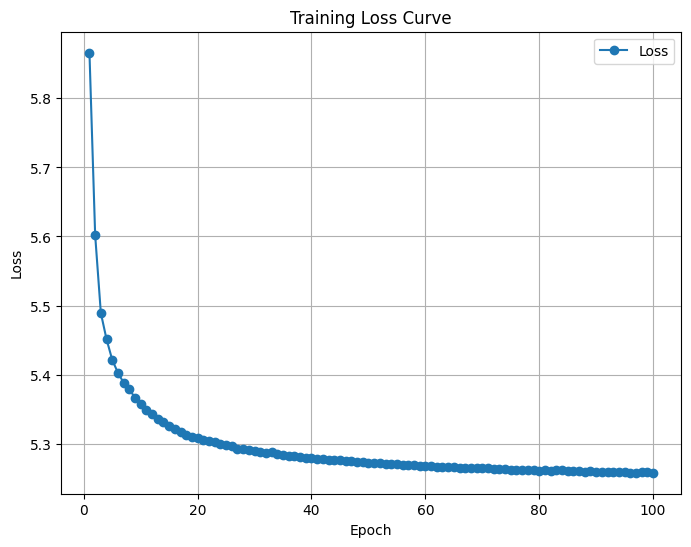

In [75]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

class CandidatePatchDataset(Dataset):
    def __init__(self, pca_data, coords, patch_size=11):
        self.data = pca_data
        self.coords = coords
        self.patch_size = patch_size

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        x, y = self.coords[idx]
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))  # [C, H, W]
        cube = torch.tensor(cube).permute(1, 2, 0)  # [H, W, C]
        cube_a, cube_b = split_cube(cube)
        cube_a = cube_a.permute(2, 0, 1)
        cube_b = cube_b.permute(2, 0, 1)
        return cube_a, cube_b


# 初始化数据集和数据加载器
pca_data_tensor = torch.tensor(pca_candidate_data).float()
dataset = CandidatePatchDataset(pca_data_tensor, coords)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
print(f"候选 patch 样本数量: {len(dataset)}") 
# 初始化网络和优化器
feature_extractor = FeatureExtractor(input_channels=90).cuda()
projection_head = ProjectionHead(input_dim=128, output_dim=8).cuda()
optimizer = optim.Adam(list(feature_extractor.parameters()) + list(projection_head.parameters()), lr=1e-4)

# 创建保存模型的文件夹
os.makedirs('./pth', exist_ok=True)

# 初始化变量用于保存损失值
loss_values = []

# 训练循环
num_epochs = 100
temperature = 1.0

for epoch in range(num_epochs):
    feature_extractor.train()
    projection_head.train()
    
    epoch_loss = 0
    for batch in dataloader:
        cube_a, cube_b = batch
        cube_a, cube_b = cube_a.cuda(), cube_b.cuda()
        
        features_a = feature_extractor(cube_a)
        features_b = feature_extractor(cube_b)
        
        proj_a = projection_head(features_a)
        proj_b = projection_head(features_b)
        
        loss = contrastive_loss(proj_a, proj_b, temperature)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 仅保存最后一个模型
model_path = 'final/Whu_original_fulld_1.pth'
torch.save(
    {
        'epoch': num_epochs,
        'feature_extractor_state_dict': feature_extractor.state_dict(),
        'projection_head_state_dict': projection_head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_values[-1],
    },
    model_path
)
print(f"Final model saved to {model_path}")

# 绘制损失值曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.savefig('final/Whu_original_fulld_1.png')
plt.show()


In [76]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)

In [77]:
def extract_labels(truth, label_dict):
    """
    从稀疏矩阵中提取标注数据，格式为 [(row, col, label), ...]。
    并将标签值映射到 [0, len(label_dict)-1] 的范围。
    """
    rows, cols, labels = truth.row, truth.col, truth.data
    # 创建从标签值到索引的映射
    label_to_index = {label_value: idx for idx, label_value in enumerate(label_dict.keys())}
    mapped_labels = [label_to_index[label] for label in labels if label in label_to_index]
    return [(row, col, label) for row, col, label in zip(rows, cols, mapped_labels)]


test_labels = extract_labels(test_truth, info['label_dict'])


print(f"Number of testing samples: {len(test_labels)}")


Number of testing samples: 204542


In [47]:

print(test_labels[:5])


[(1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0), (5, 0, 0)]


In [78]:
from collections import Counter


test_label_counts = Counter([label for _, _, label in test_labels])


print("Testing label distribution:", test_label_counts)


Testing label distribution: Counter({6: 67056, 3: 63212, 0: 34511, 5: 11854, 1: 8374, 7: 7124, 8: 5229, 4: 4151, 2: 3031})


In [79]:
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import numpy as np
import torch
from sklearn.decomposition import PCA

# 提取立方块函数
def extract_cube(data, x, y, size):
    """
    从高光谱图像中提取一个立方块，并在边缘不足时进行填充。
    参数:
        data: 高光谱数据, 形状为 [C, H, W]
        x, y: 中心像素的坐标
        size: 立方块的大小 (s, s)
    返回:
        cube: 提取的立方块, 形状为 [C, s, s]
    """
    c, h, w = data.shape
    half_size = size[0] // 2
    x_min = max(0, x - half_size)
    x_max = min(h, x + half_size + 1)
    y_min = max(0, y - half_size)
    y_max = min(w, y + half_size + 1)
    
    cube = data[:, x_min:x_max, y_min:y_max]

    # 对称填充，确保形状为 (C, s, s)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (max(0, half_size - x), max(0, x + half_size + 1 - h)),  # 高度填充
        (max(0, half_size - y), max(0, y + half_size + 1 - w)),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="reflect")
    return cube


# PCA 降维函数
def apply_pca_train_only(hsi_data, train_truth, num_components=20):
    """
    使用训练区域的光谱数据训练 PCA 模型，并应用到整个数据集。
    参数:
        hsi_data: 高光谱数据, 形状为 [C, H, W]
        train_truth: coo_array, 训练区域的稀疏矩阵，表示训练样本的位置
        num_components: 保留的主成分数量
    返回:
        pca_data: 降维后的数据, 形状为 [num_components, H, W]
        explained_variance_ratio: PCA 的累计解释方差比
    """
    c, h, w = hsi_data.shape
    rows, cols = train_truth.row, train_truth.col  # 提取训练区域的行列索引

    # 提取训练区域的光谱数据 [num_samples, num_channels]
    train_spectra = hsi_data[:, rows, cols].T  # 转置为 [num_samples, num_channels]

    # 在训练区域数据上拟合 PCA
    pca = PCA(n_components=num_components, svd_solver='auto')

    pca.fit(train_spectra)  # 仅在训练区域数据上训练 PCA

    # 转换整个数据集
    reshaped_data = hsi_data.reshape(c, -1).T  # [H×W, C]
    reduced_data = pca.transform(reshaped_data)  # 降维 [H×W, num_components]

    # 恢复为原始图像的形状
    pca_data = reduced_data.T.reshape(num_components, h, w)  # [num_components, H, W]
    
    return pca_data, pca.explained_variance_ratio_


# 分类数据集定义
class ClassificationDataset(Dataset):
    def __init__(self, data, labels, patch_size=11):
        """
        构造分类数据集。
        参数:
            data: PCA 降维后的数据 [C, H, W]
            labels: [(row, col, label), ...]，标注的样本
            patch_size: 立方块大小 (patch_size, patch_size)
        """
        self.data = data
        self.labels = labels
        self.patch_size = patch_size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y, label = self.labels[idx]
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))  # 提取立方块
        cube_tensor = torch.tensor(cube).float()  # 转换为浮点张量
        return cube_tensor, torch.tensor(label - 1, dtype=torch.long)



# 从稀疏矩阵 train_truth 中提取训练样本标签 [(row, col, label), ...]
train_labels = [
    (r, c, label) 
    for r, c, label in zip(train_truth.row, train_truth.col, train_truth.data)
]

# 应用 PCA（在训练区域上）
pca_data, explained_variance_ratio = apply_pca_train_only(whu, train_truth, num_components=90)

# 构造训练和测试数据集
train_dataset = ClassificationDataset(pca_data, train_labels, patch_size=11)

test_labels = [
    (r, c, label) 
    for r, c, label in zip(test_truth.row, test_truth.col, test_truth.data)
]
test_dataset = ClassificationDataset(pca_data, test_labels, patch_size=11)

# 定义 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 打印样本信息
print(f"PCA 降维后的数据形状: {pca_data.shape}")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")


PCA 降维后的数据形状: (90, 550, 400)
Number of training samples: 90
Number of testing samples: 204542


加载对比学习训练的模型权重

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义特征提取器
class FeatureExtractor(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # Flatten to [batch_size, features]

# 加载对比学习的模型权重
checkpoint_path = "./final/Whu_original_fulld_1.pth"  # 修改为对比学习模型的路径
#checkpoint_path = "final/Whu_original_20d_1.pth"
checkpoint = torch.load(checkpoint_path)

# 确保权重文件中包含特征提取器的权重
if 'feature_extractor_state_dict' not in checkpoint:
    raise KeyError("Checkpoint does not contain 'feature_extractor_state_dict'. Please check the file.")



In [82]:
# 初始化特征提取器（与对比学习阶段一致的输入通道数为 20）
feature_extractor = FeatureExtractor(input_channels=90).cuda()

# 加载所有预训练权重
feature_extractor.load_state_dict(checkpoint['feature_extractor_state_dict'])
print("Loaded pre-trained weights for the entire feature extractor.")

# 检查冻结状态（设置所有层参数为可微调）
for param in feature_extractor.parameters():
    param.requires_grad = True  # 解冻所有参数

# 定义分类头
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# 修改输入维度为 128（特征提取器的输出维度）
classification_head = ClassificationHead(input_dim=128, num_classes=15).cuda()


# 定义优化器
optimizer = optim.Adam([
    {"params": feature_extractor.parameters(), "lr": 1e-4},  # 微调特征提取器
    {"params": classification_head.parameters(), "lr": 1e-3},  # 分类头
])

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 训练分类头和特征提取器
def train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=50):
    feature_extractor.train()  # 微调特征提取器
    classification_head.train()  # 训练分类头

    for epoch in range(num_epochs):
        epoch_loss = 0
        for cubes, labels in train_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征
            features = feature_extractor(cubes)

            # 分类头进行训练
            outputs = classification_head(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# 运行训练函数
train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=200)


Loaded pre-trained weights for the entire feature extractor.
Epoch [1/200], Loss: 3.0668
Epoch [2/200], Loss: 2.7918
Epoch [3/200], Loss: 2.5406
Epoch [4/200], Loss: 2.3147
Epoch [5/200], Loss: 2.1135
Epoch [6/200], Loss: 1.9380
Epoch [7/200], Loss: 1.7856
Epoch [8/200], Loss: 1.6543
Epoch [9/200], Loss: 1.5407
Epoch [10/200], Loss: 1.4411
Epoch [11/200], Loss: 1.3528
Epoch [12/200], Loss: 1.2741
Epoch [13/200], Loss: 1.2026
Epoch [14/200], Loss: 1.1375
Epoch [15/200], Loss: 1.0776
Epoch [16/200], Loss: 1.0221
Epoch [17/200], Loss: 0.9699
Epoch [18/200], Loss: 0.9200
Epoch [19/200], Loss: 0.8723
Epoch [20/200], Loss: 0.8264
Epoch [21/200], Loss: 0.7828
Epoch [22/200], Loss: 0.7412
Epoch [23/200], Loss: 0.7018
Epoch [24/200], Loss: 0.6645
Epoch [25/200], Loss: 0.6292
Epoch [26/200], Loss: 0.5957
Epoch [27/200], Loss: 0.5637
Epoch [28/200], Loss: 0.5333
Epoch [29/200], Loss: 0.5043
Epoch [30/200], Loss: 0.4768
Epoch [31/200], Loss: 0.4505
Epoch [32/200], Loss: 0.4255
Epoch [33/200], Loss

In [72]:
num_classes = 9

In [83]:
import torch
from sklearn.metrics import cohen_kappa_score

def evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes):
    """
    评估分类模型的性能，并输出详细预测结果和分布。

    参数:
        feature_extractor: 冻结的特征提取器
        classification_head: 分类头
        test_loader: 测试数据加载器
        num_classes: 总类别数
    """
    feature_extractor.eval()
    classification_head.eval()

    correct = 0
    total = 0

    # 初始化预测计数，并移动到 GPU
    prediction_counts = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_correct = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_total = torch.zeros(num_classes, dtype=torch.int64).cuda()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征并进行预测
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            _, predicted = torch.max(outputs, 1)

            # 更新统计信息
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            prediction_counts += torch.bincount(predicted, minlength=num_classes).cuda()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

            # 保存详细信息
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    overall_accuracy = correct / total

    # Average Accuracy (每个类别的平均准确率)
    average_accuracy = (class_correct.float() / class_total.float()).mean().item()

    # Per-class Accuracy
    per_class_accuracy = class_correct.float() / class_total.float()

    # Kappa 系数
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}")

    print("\nPrediction Distribution:")
    for cls, count in enumerate(prediction_counts.cpu()):  # 将分布从 GPU 移回 CPU
        print(f"Class {cls}: {count} predictions")

    print("\nPer-class Accuracy:")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"Class {cls}: {acc:.4f}")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"{acc:.4f}")
    return overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy.cpu().numpy()


# 调用示例
overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy = evaluate_classification_model_with_details(
    feature_extractor, classification_head, test_loader, num_classes=num_classes
)


Overall Accuracy: 0.9474
Average Accuracy: 0.9313
Kappa Coefficient: 0.9317

Prediction Distribution:
Class 0: 35297 predictions
Class 1: 9349 predictions
Class 2: 4742 predictions
Class 3: 56468 predictions
Class 4: 6789 predictions
Class 5: 11225 predictions
Class 6: 66888 predictions
Class 7: 9509 predictions
Class 8: 4275 predictions

Per-class Accuracy:
Class 0: 0.9946
Class 1: 0.9331
Class 2: 0.9957
Class 3: 0.8869
Class 4: 0.9475
Class 5: 0.9432
Class 6: 0.9964
Class 7: 0.9672
Class 8: 0.7168
0.9946
0.9331
0.9957
0.8869
0.9475
0.9432
0.9964
0.9672
0.7168
